In [1]:
import torch
import numpy as np

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

In [2]:

def rand_sparse_matrix(rows, cols, connection_rate):

    assert 0 < connection_rate <= 1, "The connection rate must be between (0,1]"

    # Calculate the number of non-zero elements
    num_elements = rows * cols
    num_nonzero = int(num_elements * connection_rate)

    # Randomly generate the position of non-zero elements
    row_indices = torch.randint(0, rows, (num_nonzero,))
    col_indices = torch.randint(0, cols, (num_nonzero,))

    # Stack row and column indices into a two-dimensional tensor
    indices = torch.stack((row_indices, col_indices))

    # Randomly generate values for non-zero elements
    values = torch.rand(num_nonzero)*2-1

    # Create Sparse Matrix
    sparse_matrix = torch.sparse_coo_tensor(indices, values, (rows, cols))

    return sparse_matrix


def Aindx2Nrange(numnodes, div, Aindx):
    node_indx = []
    nodes_per_div = numnodes // abs(div)
    if isinstance(Aindx, list) == False: Aindx = [Aindx]

    for indx in Aindx:
        # Calculate the start and end indices for the specified division
        start_idx = (indx-1) * nodes_per_div
        end_idx = indx * nodes_per_div - 1
        
        # Create the output range
        node_indx.extend(range(start_idx, end_idx + 1))


    return node_indx


def adam_update(m, v, dw, beta1, beta2, t, epsilon=1e-8):
    # Update first-order moment estimation
    m = beta1 * m + (1 - beta1) * dw
    v = beta2 * v + (1 - beta2) * (dw ** 2)
    
    # First and Second Order Moment Estimation for Deviation Correction Calculation
    m_corr = m / (1 - beta1 ** t)
    v_corr = v / (1 - beta2 ** t)
    
    # Calculate update value
    update = m_corr / (torch.sqrt(v_corr) + epsilon)
    
    return update, m, v

def linear(x):
    return x

def linear_d(x):
    return torch.ones_like(x)

def tanh(x):
    return torch.tanh(x)

def tanh_d(x):
    return 1 - torch.tanh(x) ** 2  

def hard_sigmoid(x):
    return torch.clamp(x,0,1)

def hard_sigmoid_d(x):
    return torch.where((x >= 0) & (x <= 1), torch.ones_like(x), torch.zeros_like(x))

def relu6(x):
    return torch.max(torch.min(x, torch.ones_like(x) * 6), torch.zeros_like(x))  

def relu6_d(x):
    return torch.where((x > 0) & (x <= 6), torch.ones_like(x), torch.zeros_like(x))

def softmax(x):
    x = x - torch.max(x, dim=1, keepdim=True)[0]  # Subtract the maximum value to prevent overflow
    return torch.exp(x) / torch.sum(torch.exp(x), dim=1, keepdim=True)



# One-hot 
def one_hot(labels, n_out):
    one_hot_labels = torch.zeros(labels.size(0), n_out)
    one_hot_labels[torch.arange(labels.size(0)), labels] = 1
    return one_hot_labels

def cross_entropy_loss(output, target):
    epsilon = 1e-8  # avoid log(0)
    output = torch.clamp(output, epsilon, 1. - epsilon)  # Limit the output to [epsilon, 1-epsilon] 
    return -torch.mean(torch.sum(target * torch.log(output), dim=1))


In [3]:
def dataset(config):
    ## Dataset
    transform = transforms.Compose([
        transforms.ToTensor(),  # 
    ])

    if config.train_task == "FMNIST" :
        config.train_eta_global = 10e-4
        train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
        test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform)
    elif config.train_task == "MNIST":
        config.train_eta_global = 10e-4
        train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
        test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)
    elif config.train_task == "CIFAR10":
        config.train_eta_global = 2e-4
        config.n_input = 32*32*3
        train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
        test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform)
    elif config.train_task == "CIFAR100":
        config.train_eta_global = 2e-4
        config.n_input = 32*32*3
        config.n_out = 100
        train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, transform=transform, download=True)
        test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, transform=transform)

    train_loader = DataLoader(dataset=train_dataset, batch_size=config.train_batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=config.train_batch_size, shuffle=False)
    return train_loader,test_loader,config


In [4]:
class FRNN_LN(torch.nn.Module):
    def __init__(self, config):
        super(FRNN_LN, self).__init__()
        # 
        self.device = config.device if hasattr(config, 'device') else torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

        self.n_input = config.n_input   # input size
        self.n_out = config.n_out       # number of classes

        self.nL_hidd = config.nL_hidd   # num of hidden layers
        self.n_hidd = config.n_hidd     # num of neurons in hidden layers
        self.n_NperU = config.n_NperU   # num of nodes per block (RE, SE, RI, SI) per layer
        self.n_NU = config.n_NU  
        self.n_RE = config.n_RE if hasattr(config, 'n_RE') else -1 # num of RE neuron in hidden layers
        self.n_SE = config.n_SE if hasattr(config, 'n_SE') else -1 # num of SE neuron in hidden layers
        self.f = config.f if hasattr(config, 'f') else tanh
        self.fd = config.fd if hasattr(config, 'fd') else tanh_d

        self.RNN_CR = config.RNN_CR if hasattr(config, 'RNN_CR') else 1 # RNN connection rate
        self.RNN_SR = config.RNN_SR if hasattr(config, 'RNN_SR') else 0.25 # Spectral radius of RNN weights

        self.RNN_t2sta = config.RNN_t2sta if hasattr(config, 'RNN_t2sta') else 8 # The number of iterations to stability (inference phase)
        self.RNN_t2sta2 = config.RNN_t2sta2 if hasattr(config, 'RNN_t2sta2') else 8 # The number of iterations to stability (training phase) 

        self.train_tmethod = config.train_tmethod if hasattr(config, 'train_tmethod') else 'AP' 
        self.train_batch_size = config.train_batch_size if hasattr(config, 'train_batch_size') else 1 # batch size
        self.train_lambda1 = config.train_lambda1 if hasattr(config, 'train_lambda1') else 0    # L2 regularization
        self.train_task = config.train_task
        self.train_fbupdaterule = config.train_fbupdaterule if hasattr(config, 'train_fbupdaterule') else 'ee'

        self.flag_feedbackLearning = config.flag_feedbackLearning  if hasattr(config, 'flag_feedbackLearning') else False # wheather the feedback weights are updated
        self.flag_RNNLearning = config.flag_RNNLearning  if hasattr(config, 'flag_RNNLearning') else False # wheather the RNN internal weights are updated
        self.flag_RNNBiasLearning = config.flag_RNNBiasLearning  if hasattr(config, 'flag_RNNBiasLearning') else False # wheather the RNN bias are updated

        self.RNN_alpha1 = config.RNN_alpha1   if hasattr(config, 'RNN_alpha1') else 0 # the RNN internal weights updating factor
        self.flag_ycz = config.flag_ycz if hasattr(config, 'flag_ycz') else False # False: STE, True: EPE
        
        self.factor_gamma1 = config.factor_gamma1  if hasattr(config, 'factor_gamma1') else 0 # the factor of feedback weights updated : 0< 1e-3  <0.1
        # if self.n_NU<0: self.n_hidd = -config.n_NperU * config.n_NU
        # else: self.n_hidd = config.n_NperU * config.n_NU

        
        self.sc_forward = config.sc_forward if hasattr(config, 'sc_forward') else 1 # additional feedforward scaling
        self.sc_forward_f = config.sc_forward_f if hasattr(config, 'sc_forward_f') else 1 # additional feedforward scaling at final layer
        self.sc_bias = config.sc_bias if hasattr(config, 'sc_bias') else 1 # RNN bias scaling
        self.sc_back = config.sc_back if hasattr(config, 'sc_back') else 1  # additional feedback scaling
        self.sc_back_f = config.sc_back_f  if hasattr(config, 'sc_back_f') else 1 # additional feedback scaling at final layer

        # self.factor_beta1 = config.factor_beta1 



        self.WinX = ( torch.rand(self.n_input, self.n_NperU, device=self.device)*2-1) * self.sc_forward * 1.0/np.sqrt(self.n_input)  # in
        self.Win, self.Wb = [], []
        for i in range(self.nL_hidd-1):
            self.Win.append( (torch.rand(self.n_NperU, self.n_NperU, device=self.device)*2-1)* self.sc_forward * 1.0/np.sqrt(self.n_NperU) )   
            self.Wb.append( (torch.rand(self.n_NperU, self.n_NperU, device=self.device)*2-1) * self.sc_back * 1.0/np.sqrt(self.n_NperU) )   
        
        self.Wr, self.Wr_s, self.bias_rnn = [], [], []
        for i in range(self.nL_hidd):
            self.Wr.append(self.initialize_Wr().to(self.device))
            self.Wr_s.append(self.Wr[i] != 0)
            self.bias_rnn.append(torch.zeros(self.n_hidd, device=self.device))

        self.W_f = (torch.rand(self.n_NperU, self.n_out, device=self.device)*2-1) * self.sc_forward_f * 1.0/np.sqrt(self.n_NperU) 
        self.bias_f = (torch.rand(self.n_out, device=self.device)*2-1) * self.sc_bias * 1.0/np.sqrt(self.n_NperU) 
        self.Wb_f = (torch.rand(self.n_out, self.n_NperU, device=self.device)*2-1)* self.sc_back_f * 1.0/np.sqrt(self.n_out) 

        # Adam
        self.opt_m_WinX = torch.zeros_like(self.WinX, device=self.device)
        self.opt_v_WinX = torch.zeros_like(self.WinX, device=self.device)

        self.opt_m_Wb_f = torch.zeros_like(self.Wb_f, device=self.device)
        self.opt_v_Wb_f = torch.zeros_like(self.Wb_f, device=self.device)

        self.opt_m_Win = [torch.zeros_like(w, device=self.device) for w in self.Win]
        self.opt_v_Win = [torch.zeros_like(w, device=self.device) for w in self.Win]

        self.opt_m_Wb = [torch.zeros_like(w, device=self.device) for w in self.Wb]
        self.opt_v_Wb = [torch.zeros_like(w, device=self.device) for w in self.Wb]

        self.opt_m_Wr = [torch.zeros_like(w, device=self.device) for w in self.Wr]
        self.opt_v_Wr = [torch.zeros_like(w, device=self.device) for w in self.Wr]

        self.opt_m_b = [torch.zeros_like(b, device=self.device) for b in self.bias_rnn]
        self.opt_v_b = [torch.zeros_like(b, device=self.device) for b in self.bias_rnn]

        self.opt_m_Wout = torch.zeros_like(self.W_f, device=self.device)
        self.opt_v_Wout = torch.zeros_like(self.W_f, device=self.device)
        self.opt_m_bias_f = torch.zeros_like(self.bias_f, device=self.device)
        self.opt_v_bias_f = torch.zeros_like(self.bias_f, device=self.device)

        self.opt_beta1 = 0.9
        self.opt_beta2 = 0.999
        self.opt_epsilon = 1e-8
        self.opt_eta = config.train_eta_global
        self.opt_t = 0

        # 
        self.z = [torch.zeros(self.train_batch_size, b.size(0), device=self.device) for b in self.bias_rnn]
        self.y = [torch.zeros(self.train_batch_size, b.size(0), device=self.device) for b in self.bias_rnn]
        self.e = [torch.zeros(self.train_batch_size, b.size(0), device=self.device) for b in self.bias_rnn]

        self.dWr = [torch.zeros_like(w, device=self.device) for w in self.Wr]
        self.dbias = [torch.zeros_like(b, device=self.device) for b in self.bias_rnn]

        self.dWin = [torch.zeros_like(w, device=self.device) for w in self.Win]
        self.dWb = [torch.zeros_like(w, device=self.device) for w in self.Wb]

        self.alpha = torch.ones([self.nL_hidd+1])
        if self.train_tmethod == 'AP':
            self.forward = self.forward_AP 
            self.backward = self.backward_AP
            self.factor_beta1 = config.factor_beta1 if hasattr(config, 'factor_beta1') else 1
            self.flag_feedbackLearning = config.flag_feedbackLearning if hasattr(config, 'flag_feedbackLearning') else False
            self.flag_FNN  = config.flag_FNN if hasattr(config, 'flag_FNN') else False


    #
    def initialize_Wr(self):
        Wr = rand_sparse_matrix(self.n_hidd, self.n_hidd, self.RNN_CR).to_dense()
        Wr = Wr / torch.abs( torch.linalg.eigvals(Wr)) .max() * self.RNN_SR
        return Wr
    
    ##
    def forward_AP(self, x):
        x = x.to(self.device)  
        self.z = [torch.zeros(x.size(0), b.size(0), device=self.device) for b in self.bias_rnn]
        self.cbias = [torch.zeros(x.size(0), b.size(0), device=self.device) for b in self.bias_rnn]

        for i in range(0, self.nL_hidd):
            if i==0:
                self.cbias[0][:, Aindx2Nrange(self.n_hidd, self.n_NU, 1)] = x.mm(self.WinX)
            else:
                self.cbias[i][:, Aindx2Nrange(self.n_hidd, self.n_NU, 1)] = self.z[i-1][:, Aindx2Nrange(self.n_hidd, self.n_NU, 2)].mm(self.Win[i-1])

            if self.flag_FNN:
                self.z[i] = self.f( self.bias_rnn[i] + self.cbias[i] )
            else:
                self.z[i] = self.It2staFout(self.Wr[i], self.z[i], self.bias_rnn[i] + self.cbias[i], self.RNN_t2sta)

        self.zfh = self.z[-1][:, Aindx2Nrange(self.n_hidd, self.n_NU, 2)].mm(self.W_f) + self.bias_f
        self.zf = softmax(self.zfh)
        return self.zf

    
    def backward_AP(self, x, y, output):
        x = x.to(self.device)
        y = y.to(self.device)
        output = output.to(self.device)
        
        #
        if self.flag_ycz == True : self.y = [z for z in self.z]
        else: self.y = [torch.zeros_like(z, device=self.device) for z in self.z]
        for i in range(self.nL_hidd-1, -1, -1):
            if i == self.nL_hidd-1:
                self.e_f = output - y  # dz3
                self.dWout = self.z[self.nL_hidd-1][:, Aindx2Nrange(self.n_hidd, self.n_NU, 2)].t().mm(self.e_f) / self.train_batch_size
                self.dbias_f = self.e_f.sum(0) / self.train_batch_size
                vt = -self.factor_beta1 * self.e_f.mm(self.Wb_f)
                if  self.n_RE>-0.1: vt[:,self.n_RE:] = 0
                self.cbias[self.nL_hidd-1][:, Aindx2Nrange(self.n_hidd, self.n_NU, 3)] += vt
            else:
                self.dWin[i] = self.z[i][:, Aindx2Nrange(self.n_hidd, self.n_NU, 2)].t().mm(self.e[i+1][:, Aindx2Nrange(self.n_hidd, self.n_NU, 1)]) / self.train_batch_size
                vt = self.e[i+1][:, Aindx2Nrange(self.n_hidd, self.n_NU, 4)]
                if  self.n_SE>-0.1: vt[:,self.n_SE:] = 0
                vt = -self.factor_beta1 * vt.mm(self.Wb[i])
                if  self.n_RE>-0.1: vt[:,self.n_RE:] = 0
                self.cbias[i][:, Aindx2Nrange(self.n_hidd, self.n_NU, 3)] += vt
            
            if self.flag_FNN:
                self.y[i] = self.f( self.bias_rnn[i] + self.cbias[i] )
            else:
                self.y[i] = self.It2staFout(self.Wr[i], self.y[i], self.bias_rnn[i] + self.cbias[i], self.RNN_t2sta2)

            self.e[i] = self.z[i] - self.y[i]
            self.dWr[i] = self.z[i].t().mm(self.e[i]) / self.train_batch_size
            self.dbias[i] = self.e[i].sum(0) / self.train_batch_size

        self.dWinX = x.t().mm(self.e[0][:, Aindx2Nrange(self.n_hidd, self.n_NU, 1)]) / self.train_batch_size

        
    def update_weights_adam(self):
        self.opt_t += 1

        dWinX, self.opt_m_WinX, self.opt_v_WinX   = adam_update(self.opt_m_WinX, self.opt_v_WinX, self.dWinX, self.opt_beta1, self.opt_beta2, self.opt_t)
        self.WinX -= self.opt_eta * self.alpha[0] * dWinX #+ self.WinX * self.train_lambda1 

        for i in range(self.nL_hidd-2, -1, -1):
            dWin, self.opt_m_Win[i], self.opt_v_Win[i]      = adam_update(self.opt_m_Win[i], self.opt_v_Win[i],   self.dWin[i], self.opt_beta1, self.opt_beta2, self.opt_t)
            self.Win[i] -= self.opt_eta * self.alpha[i+1] * dWin #+ self.Win[i] * self.train_lambda1 


        dWout, self.opt_m_Wout, self.opt_v_Wout    = adam_update(self.opt_m_Wout, self.opt_v_Wout, self.dWout, self.opt_beta1, self.opt_beta2, self.opt_t)
        self.W_f -= self.opt_eta * self.alpha[-1] * dWout #+ self.W_f * self.train_lambda1 


        if self.flag_RNNLearning: 
            for i in range(0, self.nL_hidd):
                dWr, self.opt_m_Wr[i], self.opt_v_Wr[i]       = adam_update(self.opt_m_Wr[i], self.opt_v_Wr[i],     self.dWr[i], self.opt_beta1, self.opt_beta2, self.opt_t)
                self.Wr[i] -= self.opt_eta * dWr * self.Wr_s[i] * self.RNN_alpha1 + self.Wr[i] * self.train_lambda1 

            
        if self.flag_RNNBiasLearning:
            for i in range(0, self.nL_hidd):
                dbias, self.opt_m_b[i], self.opt_v_b[i]   = adam_update(self.opt_m_b[i], self.opt_v_b[i],       self.dbias[i], self.opt_beta1, self.opt_beta2, self.opt_t)
                self.bias_rnn[i] -= self.opt_eta * self.alpha[i] * dbias + self.bias_rnn[i] * self.train_lambda1

            dbias_f, self.opt_m_bias_f, self.opt_v_bias_f    = adam_update(self.opt_m_bias_f, self.opt_v_bias_f, self.dbias_f, self.opt_beta1, self.opt_beta2, self.opt_t)
            self.bias_f -= self.opt_eta * self.alpha[-1] * dbias_f #+ self.bias_f * self.train_lambda1 

        if self.flag_feedbackLearning: 
            for i in range(self.nL_hidd-2, -1, -1):
                dWb, self.opt_m_Wb[i], self.opt_v_Wb[i]    = adam_update(self.opt_m_Wb[i], self.opt_v_Wb[i], self.dWb[i], self.opt_beta1, self.opt_beta2, self.opt_t)
                self.Wb[i] += self.opt_eta * self.factor_gamma1  * dWb #+ self.Wb[i] * self.train_lambda1 
                
            dWb_f, self.opt_m_Wb_f, self.opt_v_Wb_f    = adam_update(self.opt_m_Wb_f, self.opt_v_Wb_f, self.dWb_f, self.opt_beta1, self.opt_beta2, self.opt_t)
            self.Wb_f += self.opt_eta * self.factor_gamma1 * dWb_f #+ self.Wb_f * self.train_lambda1 

        return self.Wr
    
    ##    
    def update_weights(self):
        self.opt_t += 1

        self.WinX -= self.opt_eta * self.alpha[0] * self.dWinX #+ self.WinX * self.train_lambda1 

        for i in range(self.nL_hidd-2, -1, -1):
            self.Win[i] -= self.opt_eta  * self.alpha[i+1] * self.dWin[i] #+ self.Win[i] * self.train_lambda1 


        self.W_f -= self.opt_eta  * self.alpha[-1] * self.dWout #+ self.W_f * self.train_lambda1 

        if self.flag_RNNLearning: 
            for i in range(0, self.nL_hidd):
                self.Wr[i] -= self.opt_eta * self.dWr[i] * self.Wr_s[i] * self.RNN_alpha1 + self.Wr[i] * self.train_lambda1 

            
        if self.flag_RNNBiasLearning:
            for i in range(0, self.nL_hidd):
                self.bias_rnn[i] -= self.opt_eta *  self.dbias[i] + self.bias_rnn[i] * self.train_lambda1

            self.bias_f -= self.opt_eta * self.dbias_f #+ self.bias_f * self.train_lambda1 

        if self.flag_feedbackLearning: 
            for i in range(self.nL_hidd-2, -1, -1):
                self.Wb[i] += self.opt_eta * self.factor_gamma1  * self.dWb[i] #+ self.Wb[i] * self.train_lambda1 
                
            self.Wb_f += self.opt_eta * self.factor_gamma1 * self.dWb_f #+ self.Wb_f * self.train_lambda1 

        return self.Wr
    

    def It2staFout(self, Wr, h, bias, itsta):
        # h = torch.zeros_like(bias,device=self.device)
        for indx in range(itsta):
            h = self.f(h.mm(Wr)+bias)
        
        return h
    
    def It2staFin(self, Wr, h, bias, itsta):
        # h = torch.zeros_like(bias,device=self.device)
        for indx in range(itsta):
            h = self.f(h).mm(Wr)+bias
        
        return h
    
    
    def It2stanF(self, Wr, h, bias, itsta):
        # h = torch.zeros_like(bias,device=self.device)
        for indx in range(itsta):
            h = (h.mm(Wr)+bias)
        
        return h

In [5]:

import matplotlib.pyplot as plt

import random
import time
from tqdm import tqdm  
from pathlib import Path

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(torch.cuda.is_available())
print(torch.cuda.get_device_name())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True
NVIDIA GeForce GTX 1650


In [6]:
class Config:
    def __init__(self):
        self.device = device
        self.n_input = 28 * 28  # input size
        self.n_out = 10         # number of classes

        self.nL_hidd = 2        # num of hidden layers
        self.n_hidd = 1024      # num of neurons in hidden layers
        self.n_NperU = 256      # num of nodes per block (RE, SE, RI, SI) per layer
        self.n_NU = self.n_hidd // self.n_NperU 
        self.n_RE = -1          # num of RE neuron in hidden layers
        self.n_SE = -1          # num of SE neuron in hidden layers

        self.f = tanh           # f tanh relu6 
        self.fd = tanh_d

        self.RNN_CR = 0.25      # RNN connection rate
        self.RNN_SR = 0.25      # Spectral radius of RNN weights

        self.RNN_t2sta = 8      # The number of iterations to stability (inference phase)
        self.RNN_t2sta2 = self.RNN_t2sta # The number of iterations to stability (training phase) 

        self.flag_ycz = False   # False: STE, True: EPE
        
        self.sc_forward = 1     # additional feedforward scaling
        self.sc_forward_f = 1   # additional feedforward scaling at final layer
        self.sc_back = np.sqrt(self.n_NperU)/1        # additional feedback scaling
        self.sc_back_f = 1      # additional feedback scaling at final layer
        self.sc_bias = 1.0      # RNN bias scaling

        self.factor_beta1 = 1   # feedback error scaling

        self.train_n_epochs = 100     # Training epochs
        self.train_batch_size = 500     # batch size
        self.train_eta_global = 1e-3    # learning rate
        self.train_fbupdaterule = 'ee'

        self.train_task = "FMNIST"      # "MNIST" "FMNIST" "CIFAR10"
        self.train_tmethod = 'AP'       # 



In [7]:

config = Config()

##
ParaName = f'demo'
Einfo = ''
res_path = Path(f"./Test")


# Parameter 1 and 2 can be any parameter in the config
## M_range for SR (Fig2c)
# M_range = [0.01,0.1,0.25,0.5,0.75,1,1.25,1.5,2]

## M_range for number of iterations, ParaRange for SR (Fig3 c)
# config.flag_ycz = False # STE
# M_range = [2,4,8,16]
# ParaRange = [0.01,0.1,0.25,0.5,0.75,1,1.25,1.5,2] 

M_range = [0] # Parameter 1 
ParaRange = [0] # Parameter 2
multitest = 1 # Repeat multiple times
#
res_path.mkdir(parents=True, exist_ok=True)
res = np.zeros((len(M_range),len(ParaRange),multitest,4,config.train_n_epochs))

for iM in range( len(M_range) ):
    for iPara in range( len(ParaRange) ):
        for  imultitest in range(multitest):

            # config.RNN_t2sta = M_range[iM]
            # config.RNN_t2sta2 = M_range[iM]
            # config.RNN_SR = ParaRange[iPara]
            # .......
            
            train_loader, test_loader, config = dataset(config)
            train_loader_gpu = [(data.to(device), target.to(device)) for data, target in train_loader]
            test_loader_gpu = [(data.to(device), target.to(device)) for data, target in test_loader]

            model = FRNN_LN(config).to(device)

            taskinfo = f'AP_L{config.nL_hidd}_{config.train_task}_{ParaName}_{M_range[iM]}_{ParaRange[iPara]}_{Einfo}'
            print(taskinfo)

            ###### Train #######
            for epoch in range(config.train_n_epochs):
                losssum = 0
                random.shuffle(train_loader_gpu)
                with tqdm(total=len(train_loader_gpu), desc=f'Epoch {epoch + 1}/{config.train_n_epochs}: ', unit='batch', ncols=80, mininterval=1) as pbar:
                    for i, (images, labels) in enumerate(train_loader_gpu):
                        # data processing
                        images = images.view(-1, config.n_input)
                        labels_one_hot = one_hot(labels, config.n_out)

                        # forward
                        outputs = model.forward(images)

                        # Calculate loss (cross entropy)
                        loss = cross_entropy_loss(outputs, labels_one_hot.to(device))
                        loss = loss.to('cpu')
                        losssum += loss.item()
                        # backp
                        outputs = model.backward(images, labels_one_hot, outputs)

                        # Update weights
                        model.update_weights_adam() #update_weights_adam

                        # Update progress bar
                        pbar.set_postfix({'loss': f'{losssum/(i+1):.6f}'})  
                        pbar.update(1)

                train_correct = 0
                train_total = 0
                losssum = 0
                for images, labels in train_loader_gpu:
                    images = images.view(-1, config.n_input)
                    labels_one_hot = one_hot(labels, config.n_out)
                    outputs = model.forward(images)

                    _, predicted = torch.max(outputs, 1)
                    # predicted = predicted.to('cpu')
                    loss = cross_entropy_loss(outputs, labels_one_hot.to(device))
                    loss = loss.to('cpu')
                    losssum += loss.item()
                    train_total += labels.size(0)
                    train_correct += (predicted == labels).sum().item()

                train_accuracy = train_correct / train_total

                test_correct = 0
                test_total = 0
                y_true = []
                y_pred = []
                for images, labels in test_loader_gpu:
                    images = images.view(-1, config.n_input)
                    outputs = model.forward(images)

                    _, predicted = torch.max(outputs, 1)
                    # predicted = predicted.to('cpu')
                    y_true.extend(labels.cpu().numpy())
                    y_pred.extend(predicted.cpu().numpy())
                    test_total += labels.size(0)
                    test_correct += (predicted == labels).sum().item()

                test_accuracy = test_correct / test_total

                res[iM][iPara][imultitest][0][epoch] = losssum
                res[iM][iPara][imultitest][1][epoch] = train_accuracy
                res[iM][iPara][imultitest][2][epoch] = test_accuracy

                current_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
                print(f'\t Loss: {res[iM][iPara][imultitest][0][epoch] :.3f},\t'
                    f'Train : {res[iM][iPara][imultitest][1][epoch] * 100:.2f}%,\t'
                    f'Test : {res[iM][iPara][imultitest][2][epoch] * 100:.2f}%,\t'
                    f'Current Time: {current_time}')
                
                if 1-train_accuracy <1e-4:
                    break

            # best result
            print(f"{taskinfo} Time: {current_time}, Epochs: {config.train_n_epochs}, Learning Rate: {config.train_eta_global}, "
                f"Best: {max(res[iM][iPara][imultitest][1]) * 100:.2f}%  {max(res[iM][iPara][imultitest][2]) * 100:.2f}%\n")
            
            
            with open(res_path/"res.txt", "a") as f:
                f.write(f"{taskinfo} Time: {current_time}: "
                        f"Best: {max(res[iM][iPara][imultitest][1]) * 100:.2f}%  {max(res[iM][iPara][imultitest][2]) * 100:.2f}%\n")

                for attr_name in dir(config):
                    if not attr_name.startswith('__') and not callable(getattr(config, attr_name)):  
                        attr_value = getattr(config, attr_name)
                        f.write(f'{attr_name}: {attr_value}  ')  
                f.write(f'\n\n')  



AP_L2_FMNIST_demo_0_0_


Epoch 1/100: 100%|██████████| 120/120 [00:02<00:00, 46.05batch/s, loss=1.821429]


	 Loss: 152.371,	Train : 66.91%,	Test : 65.90%,	Current Time: 2025-05-27 11:59:34


Epoch 2/100: 100%|██████████| 120/120 [00:02<00:00, 49.22batch/s, loss=0.961057]


	 Loss: 89.643,	Train : 77.16%,	Test : 76.15%,	Current Time: 2025-05-27 11:59:37


Epoch 3/100: 100%|██████████| 120/120 [00:02<00:00, 47.56batch/s, loss=0.644573]


	 Loss: 68.028,	Train : 81.71%,	Test : 80.65%,	Current Time: 2025-05-27 11:59:41


Epoch 4/100: 100%|██████████| 120/120 [00:02<00:00, 47.77batch/s, loss=0.526588]


	 Loss: 59.304,	Train : 83.25%,	Test : 81.97%,	Current Time: 2025-05-27 11:59:45


Epoch 5/100: 100%|██████████| 120/120 [00:02<00:00, 47.01batch/s, loss=0.472908]


	 Loss: 54.043,	Train : 84.54%,	Test : 83.23%,	Current Time: 2025-05-27 11:59:49


Epoch 6/100: 100%|██████████| 120/120 [00:02<00:00, 47.70batch/s, loss=0.440103]


	 Loss: 51.588,	Train : 85.07%,	Test : 83.49%,	Current Time: 2025-05-27 11:59:52


Epoch 7/100: 100%|██████████| 120/120 [00:02<00:00, 47.74batch/s, loss=0.417410]


	 Loss: 48.896,	Train : 85.77%,	Test : 84.24%,	Current Time: 2025-05-27 11:59:56


Epoch 8/100: 100%|██████████| 120/120 [00:02<00:00, 48.42batch/s, loss=0.399604]


	 Loss: 46.673,	Train : 86.42%,	Test : 84.91%,	Current Time: 2025-05-27 12:00:00


Epoch 9/100: 100%|██████████| 120/120 [00:02<00:00, 47.44batch/s, loss=0.385109]


	 Loss: 45.537,	Train : 86.73%,	Test : 85.14%,	Current Time: 2025-05-27 12:00:03


Epoch 10/100: 100%|█████████| 120/120 [00:02<00:00, 48.42batch/s, loss=0.372872]


	 Loss: 43.696,	Train : 87.33%,	Test : 85.61%,	Current Time: 2025-05-27 12:00:07


Epoch 11/100: 100%|█████████| 120/120 [00:02<00:00, 48.46batch/s, loss=0.362207]


	 Loss: 42.723,	Train : 87.53%,	Test : 85.67%,	Current Time: 2025-05-27 12:00:11


Epoch 12/100: 100%|█████████| 120/120 [00:02<00:00, 47.93batch/s, loss=0.352529]


	 Loss: 41.590,	Train : 87.78%,	Test : 85.81%,	Current Time: 2025-05-27 12:00:15


Epoch 13/100: 100%|█████████| 120/120 [00:02<00:00, 46.93batch/s, loss=0.343671]


	 Loss: 40.406,	Train : 88.19%,	Test : 86.59%,	Current Time: 2025-05-27 12:00:18


Epoch 14/100: 100%|█████████| 120/120 [00:02<00:00, 48.89batch/s, loss=0.337700]


	 Loss: 39.495,	Train : 88.45%,	Test : 86.71%,	Current Time: 2025-05-27 12:00:22


Epoch 15/100: 100%|█████████| 120/120 [00:02<00:00, 49.57batch/s, loss=0.330328]


	 Loss: 38.757,	Train : 88.63%,	Test : 86.81%,	Current Time: 2025-05-27 12:00:26


Epoch 16/100: 100%|█████████| 120/120 [00:02<00:00, 49.55batch/s, loss=0.322469]


	 Loss: 38.486,	Train : 88.76%,	Test : 86.74%,	Current Time: 2025-05-27 12:00:29


Epoch 17/100: 100%|█████████| 120/120 [00:02<00:00, 49.74batch/s, loss=0.317751]


	 Loss: 37.260,	Train : 89.08%,	Test : 86.92%,	Current Time: 2025-05-27 12:00:33


Epoch 18/100: 100%|█████████| 120/120 [00:02<00:00, 49.68batch/s, loss=0.310678]


	 Loss: 36.712,	Train : 89.11%,	Test : 86.90%,	Current Time: 2025-05-27 12:00:37


Epoch 19/100: 100%|█████████| 120/120 [00:02<00:00, 49.00batch/s, loss=0.304317]


	 Loss: 35.593,	Train : 89.50%,	Test : 87.23%,	Current Time: 2025-05-27 12:00:40


Epoch 20/100: 100%|█████████| 120/120 [00:02<00:00, 47.06batch/s, loss=0.298037]


	 Loss: 34.794,	Train : 89.80%,	Test : 87.35%,	Current Time: 2025-05-27 12:00:44


Epoch 21/100: 100%|█████████| 120/120 [00:02<00:00, 46.75batch/s, loss=0.292989]


	 Loss: 34.759,	Train : 89.72%,	Test : 87.31%,	Current Time: 2025-05-27 12:00:48


Epoch 22/100: 100%|█████████| 120/120 [00:02<00:00, 46.27batch/s, loss=0.287782]


	 Loss: 33.821,	Train : 89.98%,	Test : 87.19%,	Current Time: 2025-05-27 12:00:52


Epoch 23/100: 100%|█████████| 120/120 [00:02<00:00, 45.98batch/s, loss=0.281911]


	 Loss: 33.147,	Train : 90.22%,	Test : 87.28%,	Current Time: 2025-05-27 12:00:56


Epoch 24/100: 100%|█████████| 120/120 [00:02<00:00, 46.62batch/s, loss=0.277789]


	 Loss: 33.395,	Train : 90.15%,	Test : 87.34%,	Current Time: 2025-05-27 12:01:00


Epoch 25/100: 100%|█████████| 120/120 [00:02<00:00, 45.47batch/s, loss=0.272459]


	 Loss: 32.078,	Train : 90.49%,	Test : 87.54%,	Current Time: 2025-05-27 12:01:03


Epoch 26/100: 100%|█████████| 120/120 [00:02<00:00, 47.70batch/s, loss=0.267638]


	 Loss: 31.174,	Train : 90.83%,	Test : 87.75%,	Current Time: 2025-05-27 12:01:07


Epoch 27/100: 100%|█████████| 120/120 [00:02<00:00, 46.95batch/s, loss=0.263107]


	 Loss: 31.236,	Train : 90.69%,	Test : 87.53%,	Current Time: 2025-05-27 12:01:11


Epoch 28/100: 100%|█████████| 120/120 [00:02<00:00, 46.64batch/s, loss=0.258799]


	 Loss: 30.130,	Train : 91.09%,	Test : 88.02%,	Current Time: 2025-05-27 12:01:15


Epoch 29/100: 100%|█████████| 120/120 [00:02<00:00, 48.11batch/s, loss=0.254365]


	 Loss: 29.672,	Train : 91.20%,	Test : 88.00%,	Current Time: 2025-05-27 12:01:19


Epoch 30/100: 100%|█████████| 120/120 [00:02<00:00, 48.27batch/s, loss=0.250616]


	 Loss: 29.115,	Train : 91.39%,	Test : 88.04%,	Current Time: 2025-05-27 12:01:22


Epoch 31/100: 100%|█████████| 120/120 [00:02<00:00, 48.72batch/s, loss=0.246135]


	 Loss: 28.553,	Train : 91.55%,	Test : 88.19%,	Current Time: 2025-05-27 12:01:26


Epoch 32/100: 100%|█████████| 120/120 [00:02<00:00, 47.00batch/s, loss=0.241530]


	 Loss: 28.300,	Train : 91.61%,	Test : 88.17%,	Current Time: 2025-05-27 12:01:30


Epoch 33/100: 100%|█████████| 120/120 [00:02<00:00, 48.39batch/s, loss=0.237889]


	 Loss: 27.382,	Train : 91.86%,	Test : 88.13%,	Current Time: 2025-05-27 12:01:34


Epoch 34/100: 100%|█████████| 120/120 [00:02<00:00, 47.76batch/s, loss=0.233785]


	 Loss: 27.146,	Train : 91.93%,	Test : 88.36%,	Current Time: 2025-05-27 12:01:37


Epoch 35/100: 100%|█████████| 120/120 [00:02<00:00, 48.89batch/s, loss=0.230333]


	 Loss: 26.928,	Train : 92.03%,	Test : 88.03%,	Current Time: 2025-05-27 12:01:41


Epoch 36/100: 100%|█████████| 120/120 [00:02<00:00, 48.12batch/s, loss=0.225426]


	 Loss: 26.157,	Train : 92.27%,	Test : 88.49%,	Current Time: 2025-05-27 12:01:45


Epoch 37/100: 100%|█████████| 120/120 [00:02<00:00, 48.30batch/s, loss=0.221526]


	 Loss: 25.679,	Train : 92.42%,	Test : 88.52%,	Current Time: 2025-05-27 12:01:48


Epoch 38/100: 100%|█████████| 120/120 [00:02<00:00, 48.02batch/s, loss=0.217333]


	 Loss: 25.935,	Train : 92.26%,	Test : 88.03%,	Current Time: 2025-05-27 12:01:52


Epoch 39/100: 100%|█████████| 120/120 [00:02<00:00, 48.66batch/s, loss=0.214917]


	 Loss: 25.375,	Train : 92.47%,	Test : 88.13%,	Current Time: 2025-05-27 12:01:56


Epoch 40/100: 100%|█████████| 120/120 [00:02<00:00, 48.74batch/s, loss=0.210380]


	 Loss: 24.592,	Train : 92.74%,	Test : 88.69%,	Current Time: 2025-05-27 12:02:00


Epoch 41/100: 100%|█████████| 120/120 [00:02<00:00, 48.56batch/s, loss=0.207403]


	 Loss: 23.835,	Train : 92.92%,	Test : 88.59%,	Current Time: 2025-05-27 12:02:03


Epoch 42/100: 100%|█████████| 120/120 [00:02<00:00, 48.62batch/s, loss=0.201929]


	 Loss: 23.921,	Train : 92.85%,	Test : 88.54%,	Current Time: 2025-05-27 12:02:07


Epoch 43/100: 100%|█████████| 120/120 [00:02<00:00, 48.10batch/s, loss=0.199389]


	 Loss: 22.955,	Train : 93.32%,	Test : 88.72%,	Current Time: 2025-05-27 12:02:11


Epoch 44/100: 100%|█████████| 120/120 [00:02<00:00, 48.37batch/s, loss=0.195390]


	 Loss: 22.327,	Train : 93.54%,	Test : 88.63%,	Current Time: 2025-05-27 12:02:14


Epoch 45/100: 100%|█████████| 120/120 [00:02<00:00, 48.09batch/s, loss=0.191996]


	 Loss: 22.475,	Train : 93.39%,	Test : 88.76%,	Current Time: 2025-05-27 12:02:18


Epoch 46/100: 100%|█████████| 120/120 [00:02<00:00, 48.27batch/s, loss=0.190528]


	 Loss: 22.178,	Train : 93.43%,	Test : 88.36%,	Current Time: 2025-05-27 12:02:22


Epoch 47/100: 100%|█████████| 120/120 [00:02<00:00, 48.06batch/s, loss=0.185514]


	 Loss: 21.216,	Train : 93.77%,	Test : 88.63%,	Current Time: 2025-05-27 12:02:26


Epoch 48/100: 100%|█████████| 120/120 [00:02<00:00, 46.99batch/s, loss=0.183009]


	 Loss: 21.066,	Train : 93.94%,	Test : 88.83%,	Current Time: 2025-05-27 12:02:30


Epoch 49/100: 100%|█████████| 120/120 [00:02<00:00, 47.52batch/s, loss=0.178736]


	 Loss: 20.447,	Train : 94.06%,	Test : 88.81%,	Current Time: 2025-05-27 12:02:33


Epoch 50/100: 100%|█████████| 120/120 [00:02<00:00, 45.96batch/s, loss=0.175314]


	 Loss: 20.359,	Train : 94.06%,	Test : 88.84%,	Current Time: 2025-05-27 12:02:37


Epoch 51/100: 100%|█████████| 120/120 [00:02<00:00, 48.05batch/s, loss=0.172029]


	 Loss: 19.573,	Train : 94.33%,	Test : 88.97%,	Current Time: 2025-05-27 12:02:41


Epoch 52/100: 100%|█████████| 120/120 [00:02<00:00, 47.28batch/s, loss=0.170026]


	 Loss: 19.552,	Train : 94.27%,	Test : 88.51%,	Current Time: 2025-05-27 12:02:45


Epoch 53/100: 100%|█████████| 120/120 [00:02<00:00, 47.58batch/s, loss=0.166367]


	 Loss: 19.722,	Train : 94.19%,	Test : 88.63%,	Current Time: 2025-05-27 12:02:49


Epoch 54/100: 100%|█████████| 120/120 [00:02<00:00, 48.40batch/s, loss=0.162005]


	 Loss: 18.360,	Train : 94.69%,	Test : 89.04%,	Current Time: 2025-05-27 12:02:52


Epoch 55/100: 100%|█████████| 120/120 [00:02<00:00, 48.92batch/s, loss=0.161029]


	 Loss: 19.875,	Train : 94.06%,	Test : 88.36%,	Current Time: 2025-05-27 12:02:56


Epoch 56/100: 100%|█████████| 120/120 [00:02<00:00, 48.85batch/s, loss=0.157632]


	 Loss: 18.042,	Train : 94.77%,	Test : 88.93%,	Current Time: 2025-05-27 12:03:00


Epoch 57/100: 100%|█████████| 120/120 [00:02<00:00, 48.98batch/s, loss=0.152505]


	 Loss: 17.336,	Train : 95.07%,	Test : 88.83%,	Current Time: 2025-05-27 12:03:03


Epoch 58/100: 100%|█████████| 120/120 [00:02<00:00, 48.91batch/s, loss=0.149706]


	 Loss: 17.126,	Train : 95.14%,	Test : 88.99%,	Current Time: 2025-05-27 12:03:07


Epoch 59/100: 100%|█████████| 120/120 [00:02<00:00, 49.13batch/s, loss=0.147922]


	 Loss: 17.401,	Train : 94.90%,	Test : 88.69%,	Current Time: 2025-05-27 12:03:11


Epoch 60/100: 100%|█████████| 120/120 [00:02<00:00, 48.89batch/s, loss=0.144550]


	 Loss: 16.818,	Train : 95.13%,	Test : 88.69%,	Current Time: 2025-05-27 12:03:14


Epoch 61/100: 100%|█████████| 120/120 [00:02<00:00, 48.86batch/s, loss=0.141543]


	 Loss: 16.117,	Train : 95.45%,	Test : 89.01%,	Current Time: 2025-05-27 12:03:18


Epoch 62/100: 100%|█████████| 120/120 [00:02<00:00, 48.59batch/s, loss=0.137785]


	 Loss: 15.386,	Train : 95.77%,	Test : 88.86%,	Current Time: 2025-05-27 12:03:22


Epoch 63/100: 100%|█████████| 120/120 [00:02<00:00, 48.22batch/s, loss=0.136464]


	 Loss: 15.104,	Train : 95.76%,	Test : 88.73%,	Current Time: 2025-05-27 12:03:25


Epoch 64/100: 100%|█████████| 120/120 [00:02<00:00, 48.71batch/s, loss=0.132319]


	 Loss: 15.218,	Train : 95.73%,	Test : 88.78%,	Current Time: 2025-05-27 12:03:29


Epoch 65/100: 100%|█████████| 120/120 [00:02<00:00, 48.49batch/s, loss=0.133119]


	 Loss: 15.061,	Train : 95.78%,	Test : 88.80%,	Current Time: 2025-05-27 12:03:33


Epoch 66/100: 100%|█████████| 120/120 [00:02<00:00, 47.58batch/s, loss=0.129988]


	 Loss: 15.150,	Train : 95.69%,	Test : 88.59%,	Current Time: 2025-05-27 12:03:37


Epoch 67/100: 100%|█████████| 120/120 [00:02<00:00, 48.73batch/s, loss=0.126544]


	 Loss: 16.280,	Train : 95.20%,	Test : 88.04%,	Current Time: 2025-05-27 12:03:40


Epoch 68/100: 100%|█████████| 120/120 [00:02<00:00, 49.05batch/s, loss=0.126258]


	 Loss: 13.932,	Train : 96.15%,	Test : 89.01%,	Current Time: 2025-05-27 12:03:44


Epoch 69/100: 100%|█████████| 120/120 [00:02<00:00, 49.01batch/s, loss=0.124318]


	 Loss: 14.030,	Train : 96.12%,	Test : 88.68%,	Current Time: 2025-05-27 12:03:48


Epoch 70/100: 100%|█████████| 120/120 [00:02<00:00, 49.03batch/s, loss=0.118867]


	 Loss: 14.044,	Train : 95.95%,	Test : 88.71%,	Current Time: 2025-05-27 12:03:51


Epoch 71/100: 100%|█████████| 120/120 [00:02<00:00, 48.93batch/s, loss=0.116390]


	 Loss: 12.684,	Train : 96.55%,	Test : 89.00%,	Current Time: 2025-05-27 12:03:55


Epoch 72/100: 100%|█████████| 120/120 [00:02<00:00, 48.93batch/s, loss=0.114838]


	 Loss: 13.100,	Train : 96.42%,	Test : 88.66%,	Current Time: 2025-05-27 12:03:59


Epoch 73/100: 100%|█████████| 120/120 [00:02<00:00, 48.74batch/s, loss=0.111442]


	 Loss: 13.508,	Train : 96.31%,	Test : 88.47%,	Current Time: 2025-05-27 12:04:02


Epoch 74/100: 100%|█████████| 120/120 [00:02<00:00, 48.99batch/s, loss=0.111599]


	 Loss: 13.689,	Train : 96.08%,	Test : 88.55%,	Current Time: 2025-05-27 12:04:06


Epoch 75/100: 100%|█████████| 120/120 [00:02<00:00, 48.91batch/s, loss=0.107836]


	 Loss: 11.852,	Train : 96.81%,	Test : 88.56%,	Current Time: 2025-05-27 12:04:10


Epoch 76/100: 100%|█████████| 120/120 [00:02<00:00, 48.26batch/s, loss=0.105991]


	 Loss: 11.828,	Train : 96.84%,	Test : 88.68%,	Current Time: 2025-05-27 12:04:13


Epoch 77/100: 100%|█████████| 120/120 [00:02<00:00, 48.76batch/s, loss=0.102886]


	 Loss: 12.061,	Train : 96.56%,	Test : 88.70%,	Current Time: 2025-05-27 12:04:17


Epoch 78/100: 100%|█████████| 120/120 [00:02<00:00, 48.62batch/s, loss=0.102800]


	 Loss: 11.766,	Train : 96.66%,	Test : 88.99%,	Current Time: 2025-05-27 12:04:21


Epoch 79/100: 100%|█████████| 120/120 [00:02<00:00, 48.72batch/s, loss=0.097072]


	 Loss: 10.715,	Train : 97.18%,	Test : 88.70%,	Current Time: 2025-05-27 12:04:24


Epoch 80/100: 100%|█████████| 120/120 [00:02<00:00, 48.95batch/s, loss=0.095330]


	 Loss: 11.103,	Train : 96.92%,	Test : 88.62%,	Current Time: 2025-05-27 12:04:28


Epoch 81/100: 100%|█████████| 120/120 [00:02<00:00, 48.77batch/s, loss=0.093018]


	 Loss: 10.459,	Train : 97.24%,	Test : 88.63%,	Current Time: 2025-05-27 12:04:32


Epoch 82/100: 100%|█████████| 120/120 [00:02<00:00, 48.96batch/s, loss=0.091867]


	 Loss: 10.220,	Train : 97.28%,	Test : 88.67%,	Current Time: 2025-05-27 12:04:35


Epoch 83/100: 100%|█████████| 120/120 [00:02<00:00, 48.89batch/s, loss=0.091112]


	 Loss: 11.945,	Train : 96.44%,	Test : 88.28%,	Current Time: 2025-05-27 12:04:39


Epoch 84/100: 100%|█████████| 120/120 [00:02<00:00, 48.82batch/s, loss=0.090478]


	 Loss: 10.092,	Train : 97.38%,	Test : 88.42%,	Current Time: 2025-05-27 12:04:43


Epoch 85/100: 100%|█████████| 120/120 [00:02<00:00, 49.03batch/s, loss=0.088897]


	 Loss: 10.195,	Train : 97.21%,	Test : 88.30%,	Current Time: 2025-05-27 12:04:46


Epoch 86/100: 100%|█████████| 120/120 [00:02<00:00, 48.89batch/s, loss=0.086395]


	 Loss: 9.176,	Train : 97.65%,	Test : 88.63%,	Current Time: 2025-05-27 12:04:50


Epoch 87/100: 100%|█████████| 120/120 [00:02<00:00, 48.80batch/s, loss=0.084495]


	 Loss: 8.746,	Train : 97.75%,	Test : 88.73%,	Current Time: 2025-05-27 12:04:54


Epoch 88/100: 100%|█████████| 120/120 [00:02<00:00, 48.89batch/s, loss=0.081608]


	 Loss: 9.393,	Train : 97.52%,	Test : 88.04%,	Current Time: 2025-05-27 12:04:57


Epoch 89/100: 100%|█████████| 120/120 [00:02<00:00, 48.76batch/s, loss=0.079214]


	 Loss: 8.859,	Train : 97.67%,	Test : 88.45%,	Current Time: 2025-05-27 12:05:01


Epoch 90/100: 100%|█████████| 120/120 [00:02<00:00, 48.81batch/s, loss=0.074787]


	 Loss: 8.335,	Train : 97.88%,	Test : 88.61%,	Current Time: 2025-05-27 12:05:05


Epoch 91/100: 100%|█████████| 120/120 [00:02<00:00, 48.92batch/s, loss=0.075829]


	 Loss: 7.888,	Train : 98.05%,	Test : 88.62%,	Current Time: 2025-05-27 12:05:09


Epoch 92/100: 100%|█████████| 120/120 [00:02<00:00, 48.89batch/s, loss=0.072277]


	 Loss: 8.491,	Train : 97.84%,	Test : 88.49%,	Current Time: 2025-05-27 12:05:12


Epoch 93/100: 100%|█████████| 120/120 [00:02<00:00, 48.80batch/s, loss=0.073453]


	 Loss: 8.072,	Train : 97.90%,	Test : 88.58%,	Current Time: 2025-05-27 12:05:16


Epoch 94/100: 100%|█████████| 120/120 [00:02<00:00, 49.08batch/s, loss=0.070562]


	 Loss: 7.590,	Train : 98.09%,	Test : 88.69%,	Current Time: 2025-05-27 12:05:20


Epoch 95/100: 100%|█████████| 120/120 [00:02<00:00, 48.56batch/s, loss=0.075008]


	 Loss: 7.976,	Train : 97.92%,	Test : 88.55%,	Current Time: 2025-05-27 12:05:23


Epoch 96/100: 100%|█████████| 120/120 [00:02<00:00, 48.52batch/s, loss=0.067693]


	 Loss: 7.406,	Train : 98.17%,	Test : 88.56%,	Current Time: 2025-05-27 12:05:27


Epoch 97/100: 100%|█████████| 120/120 [00:02<00:00, 47.90batch/s, loss=0.066187]


	 Loss: 7.462,	Train : 98.06%,	Test : 88.32%,	Current Time: 2025-05-27 12:05:31


Epoch 98/100: 100%|█████████| 120/120 [00:02<00:00, 48.57batch/s, loss=0.065360]


	 Loss: 9.529,	Train : 97.20%,	Test : 87.83%,	Current Time: 2025-05-27 12:05:34


Epoch 99/100: 100%|█████████| 120/120 [00:02<00:00, 48.83batch/s, loss=0.063124]


	 Loss: 7.125,	Train : 98.22%,	Test : 88.50%,	Current Time: 2025-05-27 12:05:38


Epoch 100/100: 100%|████████| 120/120 [00:02<00:00, 48.84batch/s, loss=0.060751]


	 Loss: 6.573,	Train : 98.42%,	Test : 88.66%,	Current Time: 2025-05-27 12:05:42
AP_L2_FMNIST_demo_0_0_ Time: 2025-05-27 12:05:42, Epochs: 100, Learning Rate: 0.001, Best: 98.42%  89.04%



FMNIST	_0	_0	_TrainAccAve:98.42%_TestAccAve:89.04%


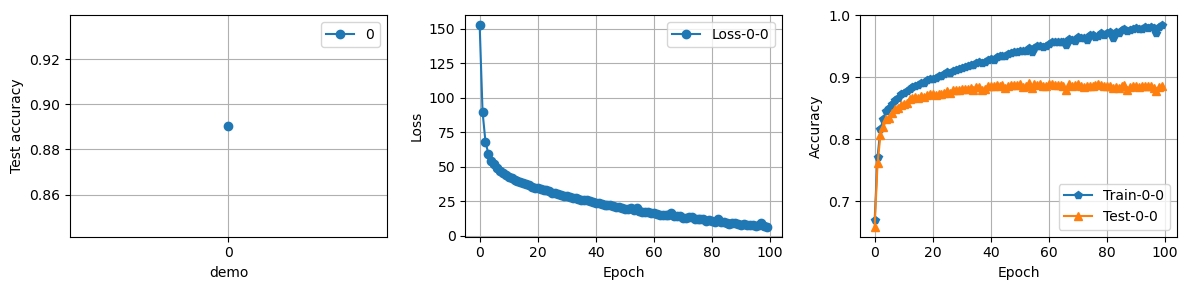

In [8]:
for iM in range( len(M_range) ):
    for iPara in range( len(ParaRange) ):        
        tt = res[iM][iPara]
        tt = np.max(tt[:,2,:], axis= -1)
        testacctt = np.mean(tt, axis=0)

        tt = res[iM][iPara]
        tt = np.max(tt[:,1,:], axis= -1)
        trainacctt = np.mean(tt, axis=0)

        print(f'{config.train_task}\t_{M_range[iM]}\t_{ParaRange[iPara]}\t_TrainAccAve:{(trainacctt)*100:5.2f}%_TestAccAve:{(testacctt)*100:5.2f}%')


index_range = np.arange(len(ParaRange))

if len(M_range)>1 and len(ParaRange)>1: 
    plt.figure(figsize=(6, 3))
    for iL in range(len(M_range)):
        tres = np.max(res[iL][:,:,:,:], axis=-1)
        plt.plot(index_range, np.mean(tres[:,:,2], axis=1), marker='o', label=f'{M_range[iL]}') 
        plt.fill_between(index_range, np.min(tres[:,:,2], axis=1), np.max(tres[:,:,2], axis=1), alpha=0.2)

    plt.xticks(index_range, ParaRange)

    plt.title('')
    plt.xlabel(f'{ParaName}')
    plt.ylabel('Test accuracy')
    plt.grid(True)
    plt.legend()

else: 
    plt.figure(figsize=(12, 3))
    plt.subplot(1,3,1)
    for iL in range(len(M_range)):
        tres = np.max(res[iL][:,:,:,:], axis=-1)
        plt.plot(index_range, np.mean(tres[:,:,2], axis=1), marker='o', label=f'{M_range[iL]}') 
        plt.fill_between(index_range, np.min(tres[:,:,2], axis=1), np.max(tres[:,:,2], axis=1), alpha=0.2)

    plt.xticks(index_range, ParaRange)

    plt.title('')
    plt.xlabel(f'{ParaName}')
    plt.ylabel('Test accuracy')
    plt.grid(True)
    plt.legend()

    for iL in range(len(M_range)):
        for iP in range(len(ParaRange)):
            for imul in range(multitest):
                plt.subplot(1,3,2)
                tres = res[iL,iP,imul,0,:]
                plt.plot(range(len(tres)), tres, marker='o', label=f'Loss-{M_range[iL]}-{ParaRange[iP]}') 
                plt.subplot(1,3,3)
                tres = res[iL,iP,imul,1,:]
                plt.plot(range(len(tres)), tres, marker='p', label=f'Train-{M_range[iL]}-{ParaRange[iP]}') 
                tres = res[iL,iP,imul,2,:]
                plt.plot(range(len(tres)), tres, marker='^', label=f'Test-{M_range[iL]}-{ParaRange[iP]}') 

    plt.subplot(1,3,2)

    plt.title('')
    plt.xlabel(f'Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(1,3,3)

    plt.title('')
    plt.xlabel(f'Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

plt.tight_layout()